In [1]:
import sys
import os
# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add it to sys.path
sys.path.append(project_root)

In [ ]:
import numpy as np
from bimpcc.dataset import get_dataset
from bimpcc.tv_reconstruct import TVReconstruct
from bimpcc.utils_recons import apply_blur
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

ModuleNotFoundError: No module named 'models'

In [3]:
def plot_experiment(true,blur,u, alpha):
    
    fig,ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].imshow(true,cmap='gray')
    ax[0].set_title('True Image')
    ax[0].axis('off')
    ax[1].imshow(blur,cmap='gray')
    ax[1].set_title('Noisy Image\nPSNR: {:.4f}'.format(psnr(true,blur)))
    ax[1].axis('off')
    ax[2].imshow(u,cmap='gray')
    ax[2].set_title(f'Reconstructed Image\nPSNR: {psnr(true,u):.4f}\n alpha = {alpha}')
    # ax[2].set_xlabel('alpha = {}'.format(alpha))
    ax[2].axis('off')

    plt.show()

In [4]:
scale = 10

In [5]:
dataset = get_dataset("cameraman",scale=scale)
true, _= dataset.get_training_data()
psf_0 = np.ones((5, 5)) / 25
blur_img = apply_blur(true, psf_0)

(np.float64(-0.5), np.float64(9.5), np.float64(9.5), np.float64(-0.5))

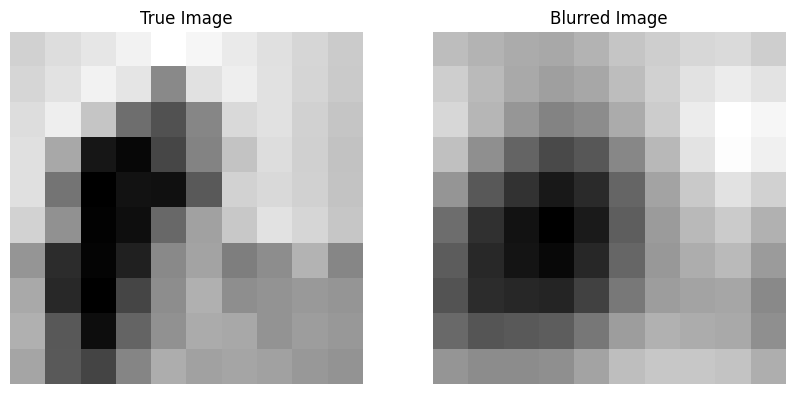

In [6]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(true,cmap='gray')
ax[0].set_title('True Image')
ax[0].axis('off')
ax[1].imshow(blur_img,cmap='gray')
ax[1].set_title('Blurred Image')
ax[1].axis('off')

In [7]:
model = TVReconstruct(true, blur_img, epsilon=1e-3)

AttributeError: 'DeblurringStateConstraintFn' object has no attribute 'u'